<a href="https://colab.research.google.com/github/hecshzye/monodepth2_paper_exp_1/blob/main/monodepth_trials_2_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monodepth2 trials_1

Checking for GPU access 

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-60601dfb-1b0a-6e34-1e0b-6fb158127163)


### Install essentials 

In [10]:
!pip install Pillow==6.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 8.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.2.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# OpenCV
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Install Tensorflow 
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Install tensorboard
!pip install tensorboardX==1.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.3 MB/s 


In [9]:
cd monodepth2

/content/monodepth2


In [10]:
ls

assets/                         kitti_utils.py  splits/
datasets/                       layers.py       test_simple.py
depth_prediction_example.ipynb  LICENSE         trainer.py
evaluate_depth.py               networks/       train.py
evaluate_pose.py                options.py      utils.py
experiments/                    __pycache__/
export_gt_depth.py              README.md


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
import networks
import seaborn
from utils import download_model_if_doesnt_exist
import PIL.Image as pil 
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow_hub as tf_hub

In [12]:
# Clone monodepth2 
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (89/89), done.


Do not download the complete dataset because of the size of the file

In [8]:
!wget -i /content/monodepth2/splits/kitti_archives_to_download.txt -P kitti_data/

--2022-06-08 06:53:27--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.181
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘kitti_data/2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-06-08 06:53:27 (190 MB/s) - ‘kitti_data/2011_09_26_calib.zip’ saved [4068/4068]

--2022-06-08 06:53:27--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
Reusing existing connection to s3.eu-central-1.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 458643963 (437M) [application/zip]
Saving to: ‘kitti_data/2011_09_26_drive_0001_sync.zip’

2011_09_26_drive_00 100%[===================>] 437.4

In [9]:
!python /content/monodepth2/test_simple.py --image_path /content/monodepth2/assets/test_image.jpg --model_name mono+stereo_640x192

-> Downloading pretrained model to models/mono+stereo_640x192.zip
   Unzipping model...
   Model unzipped to models/mono+stereo_640x192
-> Loading model from  models/mono+stereo_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved predictions to:
   - /content/monodepth2/assets/test_image_disp.jpeg
   - /content/monodepth2/assets/test_image_disp.npy
-> Done!


Weights & Network Setups

In [51]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

Loading the test image & processing

In [55]:
image_path = "/content/monodepth2/assets/ikea_1.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

Predicting using the PyTorch model

In [56]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

Plot

### PLOT_1

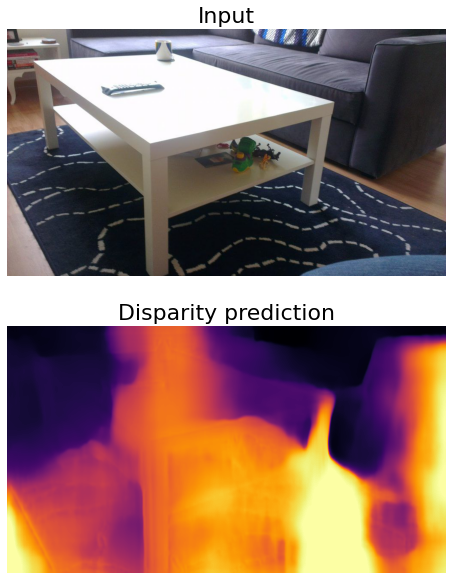

In [57]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='inferno', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

### PLOT_2

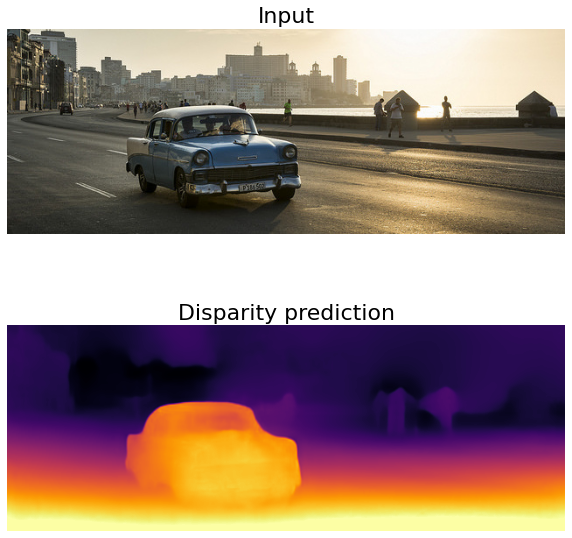

In [18]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='inferno', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

### PLOT_3

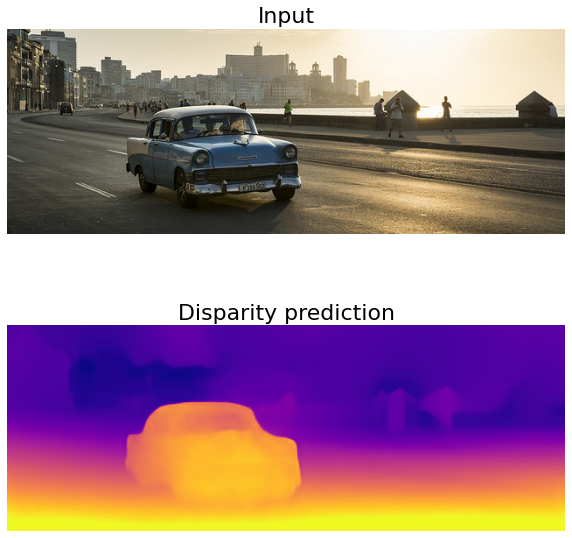

In [19]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='plasma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

### PLOT_4

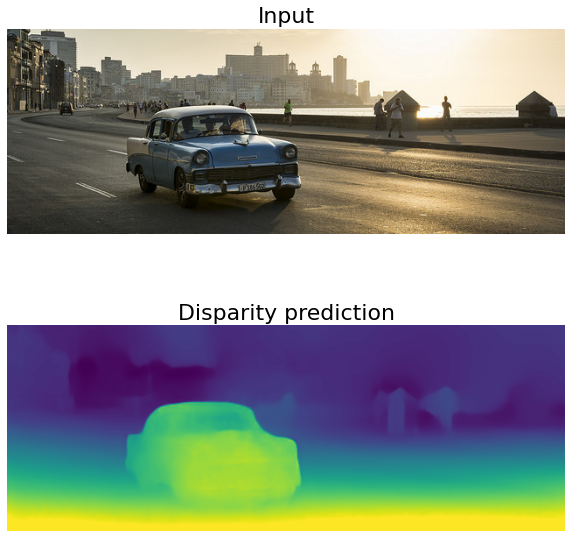

In [20]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='viridis', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');